In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

sys.path.append('../')
from src.utils import parallel_apply
from src.feature_extraction import add_features_in_group

warnings.filterwarnings('ignore')

DIR = '/mnt/ml-team/minerva/open-solutions/home-credit'

In [2]:
description = pd.read_csv(os.path.join(DIR,'data/HomeCredit_columns_description.csv'),encoding = 'latin1')
application = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/application_train.csv'))
installments = pd.read_csv(os.path.join(DIR, 'files/unzipped_data/installments_payments.csv'))

In [3]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [4]:
installments_one = installments[installments['SK_ID_CURR'] == 199697]

# Preprocessing
## Solution 3

# Feature Engineering
## Solution 3

## Aggregations

In [5]:
INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_INSTALMENT',
                   'AMT_PAYMENT',
                   'DAYS_ENTRY_PAYMENT',
                   'DAYS_INSTALMENT',
                   'NUM_INSTALMENT_NUMBER',
                   'NUM_INSTALMENT_VERSION'
                   ]:
        INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES.append((select, agg))
INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES = [(['SK_ID_CURR'], INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES)]

In [6]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(INSTALLMENTS_PAYMENTS_AGGREGATION_RECIPIES):
    group_object = installments.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        application = application.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

In [7]:
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_ID_CURR_sum_DAYS_ENTRY_PAYMENT,SK_ID_CURR_sum_DAYS_INSTALMENT,SK_ID_CURR_sum_NUM_INSTALMENT_NUMBER,SK_ID_CURR_sum_NUM_INSTALMENT_VERSION,SK_ID_CURR_var_AMT_INSTALMENT,SK_ID_CURR_var_AMT_PAYMENT,SK_ID_CURR_var_DAYS_ENTRY_PAYMENT,SK_ID_CURR_var_DAYS_INSTALMENT,SK_ID_CURR_var_NUM_INSTALMENT_NUMBER,SK_ID_CURR_var_NUM_INSTALMENT_VERSION
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-5993.0,-5605.0,190.0,20.0,1.011641e+08,1.011641e+08,29604.257310,28500.000000,31.666667,0.052632
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-34633.0,-34454.0,127.0,26.0,1.221966e+10,1.221966e+10,573541.810000,573735.890000,9.826667,0.040000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-2285.0,-2262.0,6.0,4.0,9.071372e+06,9.071372e+06,1157.333333,900.000000,1.000000,0.333333
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-4346.0,-4036.0,71.0,18.0,2.825681e+10,2.825681e+10,39222.116667,31817.000000,8.395833,0.116667
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-68128.0,-67888.0,465.0,77.0,6.166821e+07,6.477128e+07,461933.971096,465297.965501,16.751748,0.141026


In [8]:
application_agg = application[groupby_aggregate_names + ['TARGET']]
application_agg_corr = abs(application_agg.corr())

In [9]:
application_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                    1.000000
SK_ID_CURR_min_DAYS_ENTRY_PAYMENT         0.058794
SK_ID_CURR_min_DAYS_INSTALMENT            0.058648
SK_ID_CURR_var_DAYS_INSTALMENT            0.052273
SK_ID_CURR_var_DAYS_ENTRY_PAYMENT         0.052071
SK_ID_CURR_mean_DAYS_ENTRY_PAYMENT        0.043992
SK_ID_CURR_mean_DAYS_INSTALMENT           0.043509
SK_ID_CURR_sum_DAYS_ENTRY_PAYMENT         0.035227
SK_ID_CURR_sum_DAYS_INSTALMENT            0.035064
SK_ID_CURR_min_NUM_INSTALMENT_VERSION     0.032039
SK_ID_CURR_sum_NUM_INSTALMENT_VERSION     0.030063
SK_ID_CURR_mean_NUM_INSTALMENT_VERSION    0.027323
SK_ID_CURR_min_AMT_PAYMENT                0.025724
SK_ID_CURR_sum_AMT_PAYMENT                0.024375
SK_ID_CURR_mean_AMT_PAYMENT               0.023169
SK_ID_CURR_min_AMT_INSTALMENT             0.020257
SK_ID_CURR_sum_AMT_INSTALMENT             0.019811
SK_ID_CURR_max_NUM_INSTALMENT_VERSION     0.018611
SK_ID_CURR_mean_AMT_INSTALMENT            0.018409
SK_ID_CURR_sum_NUM_INSTALMENT_N

# Solution 4

In [10]:
positive_ID = application[application['TARGET']==1]['SK_ID_CURR'].tolist()
positive_ID[:4]

[100002, 100031, 100047, 100049]

In [11]:
value_counts = installments[installments['SK_ID_CURR'].isin(positive_ID)]['SK_ID_CURR'].value_counts()

In [12]:
value_counts.head()

192083    324
179215    318
226002    308
351708    302
200356    301
Name: SK_ID_CURR, dtype: int64

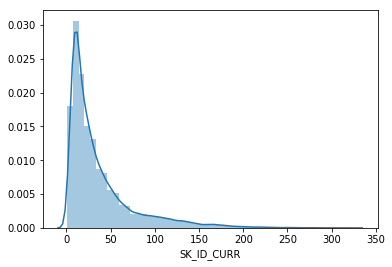

In [13]:
sns.distplot(value_counts)

In [14]:
installments_one = installments[installments['SK_ID_CURR']==328162]

In [15]:
installments_one.sort_values(['DAYS_INSTALMENT'],ascending=False).head(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8768764,1249189,328162,0.0,145,-18.0,-20.0,13500.000,13500.000
10636162,1249189,328162,0.0,146,-20.0,-20.0,9000.000,9000.000
9049702,1710115,328162,1.0,23,-34.0,-34.0,59670.045,59670.045
10593207,1249189,328162,0.0,143,-49.0,-56.0,13500.000,13500.000
7692667,1249189,328162,0.0,144,-56.0,-56.0,9000.000,9000.000
9225287,1710115,328162,1.0,22,-64.0,-64.0,59670.045,59670.045
9981049,1249189,328162,0.0,141,-79.0,-81.0,13500.000,13500.000
9232247,1249189,328162,0.0,142,-81.0,-81.0,9000.000,9000.000
8720025,1710115,328162,1.0,21,-94.0,-123.0,59670.045,888.030
10401336,1710115,328162,1.0,21,-94.0,-92.0,59670.045,58782.015


In [16]:
# installments_ = installments[installments['SK_ID_CURR'].isin(positive_ID[:100])]
installments_ = installments.sample(10000)
installments_['instalment_paid_late_in_days'] = installments_['DAYS_ENTRY_PAYMENT'] - installments_['DAYS_INSTALMENT'] 
installments_['instalment_paid_late'] = (installments_['instalment_paid_late_in_days'] > 0).astype(int)
installments_['instalment_paid_over_amount'] = installments_['AMT_PAYMENT'] - installments_['AMT_INSTALMENT']
installments_['instalment_paid_over'] = (installments_['instalment_paid_over_amount'] > 0).astype(int)

In [17]:
def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg
        
        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                columns={feature_name: '{}_{}'.format(feature_name,
                                                                                                      agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features

In [18]:
features = pd.DataFrame({'SK_ID_CURR':installments_['SK_ID_CURR'].unique()})
groupby = installments_.groupby(['SK_ID_CURR'])

In [19]:
installments_.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,instalment_paid_late_in_days,instalment_paid_late,instalment_paid_over_amount,instalment_paid_over
12273851,1825845,445592,0.0,47,-1277.0,-1277.0,271.710,271.710,0.0,0,0.000,0
12797850,2468649,434740,1.0,2,-554.0,-558.0,27565.965,27565.965,-4.0,0,0.000,0
9561154,2107365,346595,1.0,3,-1986.0,-1999.0,3711.645,3711.645,-13.0,0,0.000,0
8154641,1555902,367975,1.0,8,-2206.0,-2216.0,2865.015,2865.015,-10.0,0,0.000,0
5688161,1438179,287123,1.0,7,-1083.0,-1114.0,7133.265,5260.410,-31.0,0,-1872.855,0


## per id aggregations

In [20]:
feature_names = []

features, feature_names = add_features('NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_late', ['sum','mean'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                     features, feature_names, groupby)

features, feature_names = add_features('instalment_paid_over', ['sum','mean'],
                                     features, feature_names, groupby)
    
display(features.head())

,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,instalment_paid_over_amount_mean,instalment_paid_over_amount_max,instalment_paid_over_amount_min,instalment_paid_over_amount_std,instalment_paid_over_amount_median,instalment_paid_over_amount_skew,instalment_paid_over_amount_kurt,instalment_paid_over_amount_iqr,instalment_paid_over_sum,instalment_paid_over_mean
0,445592,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.000,0.000,0.000,NaN,0.000,NaN,-3.0,0.0,0,0.0
1,434740,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.000,0.000,0.000,NaN,0.000,NaN,-3.0,0.0,0,0.0
2,346595,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.000,0.000,0.000,NaN,0.000,NaN,-3.0,0.0,0,0.0
3,367975,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.000,0.000,0.000,NaN,0.000,NaN,-3.0,0.0,0,0.0
4,287123,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,-1872.855,-1872.855,-1872.855,NaN,-1872.855,NaN,-3.0,0.0,0,0.0


## Per id k last installment information

In [21]:
def last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    features = {}

    for period in periods:
        gr_period = gr_[gr_['DAYS_INSTALMENT'] >= (-1) * period]

        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    return features

In [22]:
func = partial(last_k_instalment_features, periods=[60, 180, 360, 720, 1500, 10e24])

g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

100%|██████████| 1/1.0 [00:31<00:00, 31.57s/it]


,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,last_720_instalment_paid_over_amount_kurt,last_720_instalment_paid_over_amount_max,last_720_instalment_paid_over_amount_mean,last_720_instalment_paid_over_amount_median,last_720_instalment_paid_over_amount_min,last_720_instalment_paid_over_amount_skew,last_720_instalment_paid_over_amount_std,last_720_instalment_paid_over_amount_sum,last_720_instalment_paid_over_count,last_720_instalment_paid_over_mean
0,445592,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
1,434740,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,-3.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1,0.0
2,346595,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
3,367975,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
4,287123,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN


In [23]:
def last_loan_features(gr):
    gr_ = gr.copy()
    last_installments_ids = gr_[gr_['DAYS_INSTALMENT']==gr_['DAYS_INSTALMENT'].max()]['SK_ID_PREV']
    gr_ = gr_[gr_['SK_ID_PREV'].isin(last_installments_ids)]

    features = {}
    features = add_features_in_group(features, gr_,
                                         'instalment_paid_late_in_days',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_,
                                         'instalment_paid_late',
                                         ['count', 'mean'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_,
                                         'instalment_paid_over_amount',
                                         ['sum', 'mean', 'max', 'min', 'std'],
                                         'last_loan_')
    features = add_features_in_group(features, gr_,
                                         'instalment_paid_over',
                                         ['count', 'mean'],
                                         'last_loan_')
    return features

In [24]:
g = parallel_apply(groupby, last_loan_features, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

100%|██████████| 1/1.0 [00:06<00:00,  6.91s/it]


,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,last_loan_instalment_paid_late_in_days_std,last_loan_instalment_paid_late_in_days_sum,last_loan_instalment_paid_late_mean,last_loan_instalment_paid_over_amount_max,last_loan_instalment_paid_over_amount_mean,last_loan_instalment_paid_over_amount_min,last_loan_instalment_paid_over_amount_std,last_loan_instalment_paid_over_amount_sum,last_loan_instalment_paid_over_count,last_loan_instalment_paid_over_mean
0,445592,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,NaN,0.0,0.0,0.000,0.000,0.000,NaN,0.000,1,0.0
1,434740,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,-4.0,0.0,0.000,0.000,0.000,NaN,0.000,1,0.0
2,346595,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,-13.0,0.0,0.000,0.000,0.000,NaN,0.000,1,0.0
3,367975,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,-10.0,0.0,0.000,0.000,0.000,NaN,0.000,1,0.0
4,287123,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,-31.0,0.0,-1872.855,-1872.855,-1872.855,NaN,-1872.855,1,0.0


## per id dynamic 

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'],ascending=False, inplace=True)
    
    features = {}

    for period in periods:
        gr_period = gr_[gr_['DAYS_INSTALMENT'] >= (-1) * period]


        features = _add_trend_feature(features,gr_period,
                                      'instalment_paid_late_in_days','{}_period_trend_'.format(period)
                                     )
        features = _add_trend_feature(features,gr_period,
                                      'instalment_paid_over_amount','{}_period_trend_'.format(period)
                                     )
    return features

def _add_trend_feature(features,gr,feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0,len(y)).reshape(-1,1)
        lr = LinearRegression()
        lr.fit(x,y)
        trend = lr.coef_[0]
    except:
        trend=np.nan
    features['{}{}'.format(prefix,feature_name)] = trend
    return features

In [27]:
func = partial(trend_in_last_k_instalment_features, periods=[60, 180, 360, 720, 1500])

g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=10000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

100%|██████████| 1/1.0 [00:09<00:00,  9.08s/it]


,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,1500_period_trend_instalment_paid_late_in_days,1500_period_trend_instalment_paid_over_amount,180_period_trend_instalment_paid_late_in_days,180_period_trend_instalment_paid_over_amount,360_period_trend_instalment_paid_late_in_days,360_period_trend_instalment_paid_over_amount,60_period_trend_instalment_paid_late_in_days,60_period_trend_instalment_paid_over_amount,720_period_trend_instalment_paid_late_in_days,720_period_trend_instalment_paid_over_amount
0,445592,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,434740,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,346595,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,367975,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,287123,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
X = application.merge(features, on='SK_ID_CURR',how='left')
X = X[features.columns.drop('SK_ID_CURR').tolist()+['TARGET']]
X.head()

,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,instalment_paid_late_in_days_sum,...,1500_period_trend_instalment_paid_over_amount,180_period_trend_instalment_paid_late_in_days,180_period_trend_instalment_paid_over_amount,360_period_trend_instalment_paid_late_in_days,360_period_trend_instalment_paid_over_amount,60_period_trend_instalment_paid_late_in_days,60_period_trend_instalment_paid_over_amount,720_period_trend_instalment_paid_late_in_days,720_period_trend_instalment_paid_over_amount,TARGET
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [29]:
X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                           1.000000
last_180_instalment_paid_late_in_days_std        0.453921
last_360_instalment_paid_over_amount_std         0.375824
last_loan_instalment_paid_late_in_days_std       0.249958
last_1500_instalment_paid_late_in_days_std       0.239323
last_1e+25_instalment_paid_late_in_days_std      0.141202
instalment_paid_late_in_days_std                 0.141202
last_60_instalment_paid_late_mean                0.122328
last_720_NUM_INSTALMENT_VERSION_std              0.104889
180_period_trend_instalment_paid_late_in_days    0.102316
last_180_instalment_paid_late_in_days_kurt       0.101563
last_180_instalment_paid_late_in_days_iqr        0.099281
last_720_instalment_paid_over_amount_std         0.097386
last_60_instalment_paid_over_amount_median       0.095789
last_60_instalment_paid_over_amount_min          0.095789
last_60_instalment_paid_over_amount_mean         0.095789
last_60_instalment_paid_over_amount_max          0.095789
last_60_NUM_IN

# Solution 5
## Period fractions

In [30]:
def last_k_instalment_features_with_fractions(gr, periods, fraction_periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'],ascending=False, inplace=True)
    
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]

        features = add_features_in_group(features,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        
        features = add_features_in_group(features,gr_period, 'instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period ,'instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features = add_features_in_group(features,gr_period,'instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    for short_period, long_period in fraction_periods:
        short_feature_names = _get_feature_names(features, short_period)
        long_feature_names = _get_feature_names(features, long_period)
        
        for short_feature, long_feature in zip(short_feature_names, long_feature_names):
            old_name_chunk = '_{}_'.format(short_period)
            new_name_chunk ='_{}by{}_fraction_'.format(short_period, long_period)
            fraction_feature_name = short_feature.replace(old_name_chunk, new_name_chunk)
            features[fraction_feature_name] = safe_div(features[short_feature], features[long_feature])
    return pd.Series(features)

def _get_feature_names(features, period):
    return sorted([feat for feat in features.keys() if '_{}_'.format(period) in feat])


def safe_div(a,b):
    try:
        return float(a)/float(b)
    except:
        return 0.0

In [31]:
func = partial(last_k_instalment_features_with_fractions, 
               periods=[1,5,10,20,50,100],
               fraction_periods=[(5,20),(5,50),(10,100)])

g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=1000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

100%|██████████| 10/10.0 [00:49<00:00,  4.77s/it]


,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,last_5by50_fraction_instalment_paid_over_amount_kurt,last_5by50_fraction_instalment_paid_over_amount_max,last_5by50_fraction_instalment_paid_over_amount_mean,last_5by50_fraction_instalment_paid_over_amount_median,last_5by50_fraction_instalment_paid_over_amount_min,last_5by50_fraction_instalment_paid_over_amount_skew,last_5by50_fraction_instalment_paid_over_amount_std,last_5by50_fraction_instalment_paid_over_amount_sum,last_5by50_fraction_instalment_paid_over_count,last_5by50_fraction_instalment_paid_over_mean
0,445592,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0
1,434740,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0
2,346595,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0
3,367975,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0
4,287123,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1.0,0.0


In [32]:
X = application.merge(features, on='SK_ID_CURR',how='left')
X = X[features.columns.drop('SK_ID_CURR').tolist()+['TARGET']]
X.head()

,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,instalment_paid_late_in_days_sum,...,last_5by50_fraction_instalment_paid_over_amount_max,last_5by50_fraction_instalment_paid_over_amount_mean,last_5by50_fraction_instalment_paid_over_amount_median,last_5by50_fraction_instalment_paid_over_amount_min,last_5by50_fraction_instalment_paid_over_amount_skew,last_5by50_fraction_instalment_paid_over_amount_std,last_5by50_fraction_instalment_paid_over_amount_sum,last_5by50_fraction_instalment_paid_over_count,last_5by50_fraction_instalment_paid_over_mean,TARGET
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [33]:
X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                     1.000000
last_180_instalment_paid_late_in_days_std                  0.453921
last_360_instalment_paid_over_amount_std                   0.375824
last_loan_instalment_paid_late_in_days_std                 0.249958
last_1500_instalment_paid_late_in_days_std                 0.239323
last_1e+25_instalment_paid_late_in_days_std                0.141202
last_5_instalment_paid_late_in_days_std                    0.141202
last_20_instalment_paid_late_in_days_std                   0.141202
instalment_paid_late_in_days_std                           0.141202
last_10_instalment_paid_late_in_days_std                   0.141202
last_100_instalment_paid_late_in_days_std                  0.141202
last_50_instalment_paid_late_in_days_std                   0.141202
last_60_instalment_paid_late_mean                          0.122328
last_720_NUM_INSTALMENT_VERSION_std                        0.104889
180_period_trend_instalment_paid_late_in_days   

In [34]:
features.columns[100:200]

Index(['last_1e+25_NUM_INSTALMENT_VERSION_skew',
       'last_1e+25_NUM_INSTALMENT_VERSION_std',
       'last_1e+25_NUM_INSTALMENT_VERSION_sum',
       'last_1e+25_instalment_paid_late_count',
       'last_1e+25_instalment_paid_late_in_days_iqr',
       'last_1e+25_instalment_paid_late_in_days_kurt',
       'last_1e+25_instalment_paid_late_in_days_max',
       'last_1e+25_instalment_paid_late_in_days_mean',
       'last_1e+25_instalment_paid_late_in_days_median',
       'last_1e+25_instalment_paid_late_in_days_min',
       'last_1e+25_instalment_paid_late_in_days_skew',
       'last_1e+25_instalment_paid_late_in_days_std',
       'last_1e+25_instalment_paid_late_in_days_sum',
       'last_1e+25_instalment_paid_late_mean',
       'last_1e+25_instalment_paid_over_amount_iqr',
       'last_1e+25_instalment_paid_over_amount_kurt',
       'last_1e+25_instalment_paid_over_amount_max',
       'last_1e+25_instalment_paid_over_amount_mean',
       'last_1e+25_instalment_paid_over_amount_median'

# Solution 5
## Period fractions

In [35]:
def last_k_instalment_features_with_fractions(gr, periods, fraction_periods):
    gr_ = gr.copy()
    
    features = {}
    features_temp = {}

    for period in periods:
        gr_period = gr_[gr_['DAYS_INSTALMENT'] >= (-1) * period]

        features_temp = add_features_in_group(features_temp,gr_period, 'NUM_INSTALMENT_VERSION', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        
        features_temp = add_features_in_group(features_temp,gr_period, 'instalment_paid_late_in_days', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features_temp = add_features_in_group(features_temp,gr_period ,'instalment_paid_late', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))
        features_temp = add_features_in_group(features_temp,gr_period ,'instalment_paid_over_amount', 
                                       ['sum','mean','max','min','std', 'median','skew', 'kurt','iqr'],
                                         'last_{}_'.format(period))
        features_temp = add_features_in_group(features_temp,gr_period,'instalment_paid_over', 
                                     ['count','mean'],
                                         'last_{}_'.format(period))        
    
    for short_period, long_period in fraction_periods:
        short_feature_names = _get_feature_names(features_temp, short_period)
        long_feature_names = _get_feature_names(features_temp, long_period)
        
        for short_feature, long_feature in zip(short_feature_names, long_feature_names):
            old_name_chunk = '_{}_'.format(short_period)
            new_name_chunk ='_{}by{}_fraction_'.format(short_period, long_period)
            fraction_feature_name = short_feature.replace(old_name_chunk, new_name_chunk)
            features[fraction_feature_name] = safe_div(features_temp[short_feature], features_temp[long_feature])
    return pd.Series(features)

def _get_feature_names(features, period):
    return sorted([feat for feat in features.keys() if '_{}_'.format(period) in feat])


def safe_div(a,b):
    try:
        return float(a)/float(b)
    except:
        return 0.0

In [36]:
func = partial(last_k_instalment_features_with_fractions, 
               periods=[60, 180, 360, 720, 1500],
               fraction_periods=[(60,180),(60,360),(180,1500),(360,1500)])

g = parallel_apply(groupby, func, index_name='SK_ID_CURR',
                   num_workers=16, chunk_size=1000).reset_index()
features = features.merge(g, on='SK_ID_CURR', how='left')

display(features.head())

100%|██████████| 10/10.0 [00:36<00:00,  3.55s/it]


,SK_ID_CURR,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,...,last_60by360_fraction_instalment_paid_over_amount_kurt,last_60by360_fraction_instalment_paid_over_amount_max,last_60by360_fraction_instalment_paid_over_amount_mean,last_60by360_fraction_instalment_paid_over_amount_median,last_60by360_fraction_instalment_paid_over_amount_min,last_60by360_fraction_instalment_paid_over_amount_skew,last_60by360_fraction_instalment_paid_over_amount_std,last_60by360_fraction_instalment_paid_over_amount_sum,last_60by360_fraction_instalment_paid_over_count,last_60by360_fraction_instalment_paid_over_mean
0,445592,0.0,0.0,0.0,0.0,NaN,0.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,434740,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,346595,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,367975,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,287123,1.0,1.0,1.0,1.0,NaN,1.0,NaN,-3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [37]:
X = application.merge(features, on='SK_ID_CURR',how='left')
X = X[features.columns.drop('SK_ID_CURR').tolist()+['TARGET']]
X.head()

,NUM_INSTALMENT_VERSION_sum,NUM_INSTALMENT_VERSION_mean,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_std,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_VERSION_skew,NUM_INSTALMENT_VERSION_kurt,NUM_INSTALMENT_VERSION_iqr,instalment_paid_late_in_days_sum,...,last_60by360_fraction_instalment_paid_over_amount_max,last_60by360_fraction_instalment_paid_over_amount_mean,last_60by360_fraction_instalment_paid_over_amount_median,last_60by360_fraction_instalment_paid_over_amount_min,last_60by360_fraction_instalment_paid_over_amount_skew,last_60by360_fraction_instalment_paid_over_amount_std,last_60by360_fraction_instalment_paid_over_amount_sum,last_60by360_fraction_instalment_paid_over_count,last_60by360_fraction_instalment_paid_over_mean,TARGET
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [38]:
X_corr = abs(X.corr())
X_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                                                       1.000000
last_180by1500_fraction_instalment_paid_late_in_days_std     0.490098
last_180_instalment_paid_late_in_days_std                    0.453921
last_360_instalment_paid_over_amount_std                     0.375824
last_loan_instalment_paid_late_in_days_std                   0.249958
last_1500_instalment_paid_late_in_days_std                   0.239323
last_360by1500_fraction_instalment_paid_late_in_days_std     0.230569
instalment_paid_late_in_days_std                             0.141202
last_10_instalment_paid_late_in_days_std                     0.141202
last_5_instalment_paid_late_in_days_std                      0.141202
last_20_instalment_paid_late_in_days_std                     0.141202
last_100_instalment_paid_late_in_days_std                    0.141202
last_50_instalment_paid_late_in_days_std                     0.141202
last_1e+25_instalment_paid_late_in_days_std                  0.141202
last_60_instalment_p

In [39]:
regex = 'last_loan.*instalment_paid_over.*'
X_corr_truncated = X_corr.sort_values('TARGET', ascending=False).filter(regex=regex, axis=0)
X_corr_truncated['TARGET']

last_loan_instalment_paid_over_amount_std     0.024186
last_loan_instalment_paid_over_mean           0.018235
last_loan_instalment_paid_over_amount_max     0.011126
last_loan_instalment_paid_over_amount_sum     0.011082
last_loan_instalment_paid_over_amount_mean    0.011067
last_loan_instalment_paid_over_amount_min     0.011003
last_loan_instalment_paid_over_count          0.005404
Name: TARGET, dtype: float64

In [40]:
colnames = X_corr_truncated.index.tolist() + ['TARGET']
X_corr_truncated[colnames]

,last_loan_instalment_paid_over_amount_std,last_loan_instalment_paid_over_mean,last_loan_instalment_paid_over_amount_max,last_loan_instalment_paid_over_amount_sum,last_loan_instalment_paid_over_amount_mean,last_loan_instalment_paid_over_amount_min,last_loan_instalment_paid_over_count,TARGET
last_loan_instalment_paid_over_amount_std,1.000000,0.835275,0.818308,0.378458,0.378458,0.518231,0.059251,0.024186
last_loan_instalment_paid_over_mean,0.835275,1.000000,0.419404,0.419365,0.418778,0.418001,0.007353,0.018235
last_loan_instalment_paid_over_amount_max,0.818308,0.419404,1.000000,0.999757,0.999822,0.999289,0.002146,0.011126
last_loan_instalment_paid_over_amount_sum,0.378458,0.419365,0.999757,1.000000,0.999808,0.999502,0.003598,0.011082
last_loan_instalment_paid_over_amount_mean,0.378458,0.418778,0.999822,0.999808,1.000000,0.999822,0.001881,0.011067
last_loan_instalment_paid_over_amount_min,0.518231,0.418001,0.999289,0.999502,0.999822,1.000000,0.005908,0.011003
last_loan_instalment_paid_over_count,0.059251,0.007353,0.002146,0.003598,0.001881,0.005908,1.000000,0.005404


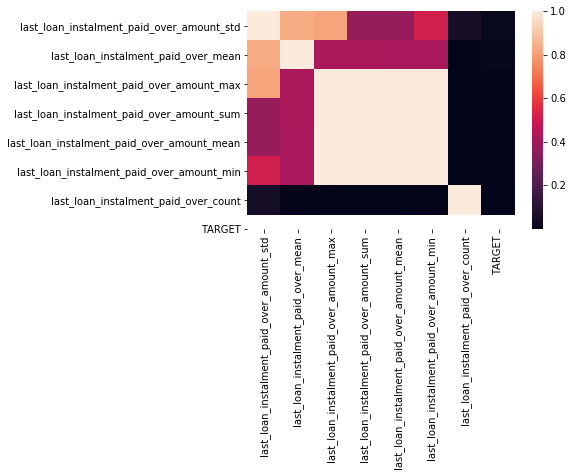

In [41]:
sns.heatmap(X_corr_truncated[colnames], 
            xticklabels=colnames,
            yticklabels=colnames)

In [42]:
installments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
5,1137312,164489,1.0,12,-1384.0,-1417.0,5970.375,5970.375
6,2234264,184693,4.0,11,-349.0,-352.0,29432.295,29432.295
7,1818599,111420,2.0,4,-968.0,-994.0,17862.165,17862.165
8,2723183,112102,0.0,14,-197.0,-197.0,70.740,70.740
9,1413990,109741,1.0,4,-570.0,-609.0,14308.470,14308.470
